<a href="https://colab.research.google.com/github/theabhinav0231/dive_into_deep_learning_book/blob/main/08_4_GoogLeNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install d2l

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.9/58.9 kB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 111.7/111.7 kB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.6/11.6 MB 80.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.1/17.1 MB 67.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.3/12.3 MB 78.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.6/62.6 kB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 34.4/34.4 MB 17.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.3/98.3 kB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 125.0/125.0 kB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 95.2/95.2 kB 6.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 44.0 MB/s eta 0:00:00
  Attempting uninstall: requests
    Found existing installation: requests 2.32.3
    Uninstalling requests-2.32.3:
      Successfull

In [2]:
import torch
from torch import nn
from torch.nn import functional as F
from d2l import torch as d2l

## **Multi-Branch Networks (GoogLeNet)**

GoogLeNet combines the strengths of NiN, repeated blocks, and multi-scale convolution kernels. It introduced a clear design pattern for CNNs with three distinct parts:

- Stem: Initial convolutions for extracting low-level image features.
- Body: The core, composed of convolutional blocks, responsible for feature extraction.
- Head: Maps extracted features to the final task (e.g., classification or detection).
The key innovation was its multi-branch convolutional design in the body, which concatenated different convolution kernel outputs (e.g., 1×1 to 11×11) rather than choosing a single kernel size. This approach efficiently captured features at multiple scales.

The basic convolutional block in GoogLeNet is called an **Inception block**.

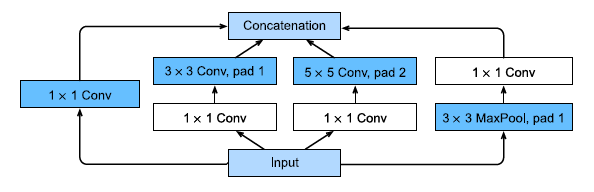


The Inception block uses four parallel branches to extract multi-scale spatial features:

- First Three Branches: Use 1×1, 3×3, and 5×5 convolutional layers to capture features at different spatial scales.
- Channel Reduction: The 3×3 and 5×5 branches include an initial 1×1 convolution to reduce the number of input channels, lowering model complexity.
- Fourth Branch: Applies a 3×3 max-pooling layer followed by a 1×1 convolution to adjust the number of channels.
- Padding: Ensures input and output have the same spatial dimensions (height and width).
- Concatenation: Outputs of all branches are concatenated along the channel dimension to form the block's output.

Key hyperparameter: the number of output channels in each layer, determining the capacity allocation among different convolution sizes.

In [3]:
class Inception(nn.Module):
# c1--c4 are the number of output channels for each branch
  def __init__(self, c1, c2, c3, c4, **kwargs):
    super(Inception, self).__init__(**kwargs)
    # Branch 1
    self.b1_1 = nn.LazyConv2d(c1, kernel_size=1)
    # Branch 2
    self.b2_1 = nn.LazyConv2d(c2[0], kernel_size=1)
    self.b2_2 = nn.LazyConv2d(c2[1], kernel_size=3, padding=1)
    # Branch 3
    self.b3_1 = nn.LazyConv2d(c3[0], kernel_size=1)
    self.b3_2 = nn.LazyConv2d(c3[1], kernel_size=5, padding=2)
    # Branch 4
    self.b4_1 = nn.MaxPool2d(kernel_size=3, stride=1, padding=1)
    self.b4_2 = nn.LazyConv2d(c4, kernel_size=1)
  def forward(self, x):
    b1 = F.relu(self.b1_1(x))
    b2 = F.relu(self.b2_2(F.relu(self.b2_1(x))))
    b3 = F.relu(self.b3_2(F.relu(self.b3_1(x))))
    b4 = F.relu(self.b4_2(self.b4_1(x)))
    return torch.cat((b1, b2, b3, b4), dim=1)

## **GoogLeNet**

GoogLeNet uses a stack of a total of 9 inception blocks, arranged
into three groups with max-pooling in between, and global average pooling in its head to
generate its estimates. Max-pooling between inception blocks reduces the dimensionality.


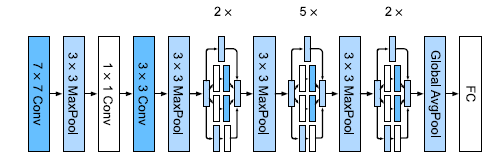

The first module uses a 64-channel 7 x 7 convolutional layer

In [6]:
class GoogleNet(d2l.Classifier):
  def b1(self):
    return nn.Sequential(
      nn.LazyConv2d(64, kernel_size=7, stride=2, padding=3),
      nn.ReLU(),
      nn.MaxPool2d(kernel_size=3, stride=2, padding=1))

The second module uses two convolutional layers: first, a 64-channel 1 x 1 convolutional
layer, followed by a 3 x 3 convolutional layer that triples the number of channels. This
corresponds to the second branch in the Inception block and concludes the design of the
body. At this point we have 192 channels.

In [8]:
@d2l.add_to_class(GoogleNet)
def b2(self):
  return nn.Sequential(
  nn.LazyConv2d(64, kernel_size=1),
  nn.ReLU(),
  nn.LazyConv2d(192, kernel_size=3, padding=1),
  nn.ReLU(),
  nn.MaxPool2d(kernel_size=3, stride=2, padding=1))

The third module connects two complete Inception blocks in series. The number of output
channels of the first Inception block is 64 + 128 + 32 + 32 = 256. This amounts to a ratio of
the number of output channels among the four branches of 2 : 4 : 1 : 1. To achieve this, we
first reduce the input dimensions by 1/2 and by 1/12 in the second and third branch respectively
to arrive at 96 = 192/2 and 16 = 192/12 channels respectively.
The number of output channels of the second Inception block is increased to 128 + 192 +
96 + 64 = 480, yielding a ratio of 128 : 192 : 96 : 64 = 4 : 6 : 3 : 2. As before, we need to
reduce the number of intermediate dimensions in the second and third channel. A scale of
1/2 and 1/8
respectively suffices, yielding 128 and 32 channels respectively. This is captured
by the arguments of the following Inception block constructors.

In [9]:
@d2l.add_to_class(GoogleNet)
def b3(self):
  return nn.Sequential(Inception(64, (96, 128), (16, 32), 32),
  Inception(128, (128, 192), (32, 96), 64),
  nn.MaxPool2d(kernel_size=3, stride=2, padding=1))

The fourth module is more complicated. It connects five Inception blocks in series, and
they have 192 + 208 + 48 + 64 = 512, 160 + 224 + 64 + 64 = 512, 128 + 256 + 64 + 64 = 512,
112 + 288 + 64 + 64 = 528, and 256 + 320 + 128 + 128 = 832 output channels, respectively.
The number of channels assigned to these branches is similar to that in the third module:
the second branch with the 3xx 3 convolutional layer outputs the largest number of channels,
followed by the first branch with only the 1 x 1 convolutional layer, the third branch with
the 5 x 5 convolutional layer, and the fourth branch with the 3 x 3 max-pooling layer. The
second and third branches will first reduce the number of channels according to the ratio.
These ratios are slightly different in different Inception blocks.

In [10]:
@d2l.add_to_class(GoogleNet)
def b4(self):
  return nn.Sequential(Inception(192, (96, 208), (16, 48), 64),
  Inception(160, (112, 224), (24, 64), 64),
  Inception(128, (128, 256), (24, 64), 64),
  Inception(112, (144, 288), (32, 64), 64),
  Inception(256, (160, 320), (32, 128), 128),
  nn.MaxPool2d(kernel_size=3, stride=2, padding=1))

The fifth module has two Inception blocks with 256 + 320 + 128 + 128 = 832 and 384 + 384 +
128 + 128 = 1024 output channels. The number of channels assigned to each branch is the
same as that in the third and fourth modules, but differs in specific values. It should be
noted that the fifth block is followed by the output layer. This block uses the global average
pooling layer to change the height and width of each channel to 1, just as in NiN. Finally,
we turn the output into a two-dimensional array followed by a fully connected layer whose
number of outputs is the number of label classes.

In [11]:
@d2l.add_to_class(GoogleNet)
def b5(self):
  return nn.Sequential(
      Inception(256, (160, 320), (32, 128), 128),
      Inception(384, (192, 384), (48, 128), 128),
      nn.AdaptiveAvgPool2d((1,1)),
      nn.Flatten())

In [12]:
@d2l.add_to_class(GoogleNet)
def __init__(self, lr=0.1, num_classes=10):
  super(GoogleNet, self).__init__()
  self.save_hyperparameters()
  self.net = nn.Sequential(self.b1(), self.b2(), self.b3(), self.b4(),
                            self.b5(), nn.LazyLinear(num_classes))
  self.net.apply(d2l.init_cnn)

In [13]:
model = GoogleNet().layer_summary((1, 1, 96, 96))

Sequential output shape:	 torch.Size([1, 64, 24, 24])
Sequential output shape:	 torch.Size([1, 192, 12, 12])
Sequential output shape:	 torch.Size([1, 480, 6, 6])
Sequential output shape:	 torch.Size([1, 832, 3, 3])
Sequential output shape:	 torch.Size([1, 1024])
Linear output shape:	 torch.Size([1, 10])


## **Training**

In [ ]:
model = GoogleNet(lr=0.01)
trainer = d2l.Trainer(max_epochs=10, num_gpus=1)
data = d2l.FashionMNIST(batch_size=128, resize=(96, 96)) # reducing input height and width from 224 to 96
model.apply_init([next(iter(data.get_dataloader(True)))[0]], d2l.init_cnn)
trainer.fit(model, data)

100%|██████████| 26.4M/26.4M [00:01<00:00, 18.5MB/s]


Extracting ../data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ../data/FashionMNIST/raw



100%|██████████| 29.5k/29.5k [00:00<00:00, 308kB/s]


Extracting ../data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ../data/FashionMNIST/raw



100%|██████████| 4.42M/4.42M [00:00<00:00, 5.51MB/s]


Extracting ../data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ../data/FashionMNIST/raw



100%|██████████| 5.15k/5.15k [00:00<00:00, 12.9MB/s]


Extracting ../data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ../data/FashionMNIST/raw



/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
